# Exercise 1: Predicting house prices with linear models

In this exercise, you will work with the Ames housing data set which we already encountered in the lectures. Your task is to evaluate the following three linear models in terms of their performance when predicting house prices:

1.  Linear regression without any regularization
2.  Ridge regression
3.  Lasso

## Data description

The data is stored in in the file [`data/ames_houses.csv`](../../data/ames_houses.csv) and can be loaded as follows:

In [1]:
import pandas as pd

# Use this path to use the CSV file from the data/ directory
file = '../../data/ames_houses.csv'

df = pd.read_csv(file, sep=',')

# Variables used in the analysis
variables = [
    'LotArea',
    'LivingArea',
    'Bathrooms',
    'Bedrooms',
    'SalePrice',
    'OverallQuality',
    'BuildingType',
    'YearBuilt',
    'CentralAir',
]

# Drop rows with any missing observation
df = df.dropna(subset=variables)

# Drop observations with large living or lot area
df = df.query('LivingArea <= 350 & LotArea <= 5000')

print(f'Number of observations: {df.shape[0]:,d}')

Number of observations: 2,755


The included variables are a simplified subset of the original data (see [here](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt) 
for a detailed description of the original variables):

1. `LotArea`: Lot size in square meters
2. `Neighborhood`: Physical locations within Ames city limits
3. `OverallQuality`: Rates the overall material and finish of the house
    (1 = very poor, 10 = excellent)
4. `OverallCondition`: Rates the overall condition of the house
    (1 = very poor, 10 = excellent)
5. `YearBuilt`: Original construction date
6. `YearRemodeled`: Remodel date (same as construction date if no remodeling or additions)
7. `BuildingType`: Type of dwelling
8. `CentralAir`: Central air conditioning (string, Y/N)
9. `LivingArea`: Above grade (ground) living area in square meters
10. `Bathrooms`: Full bathrooms above grade
11. `Bedrooms`: Bedrooms above grade (does not include basement bedrooms)
12. `Fireplaces`: Number of fireplaces
13. `SalePrice`: Sale price in thousands of USD
14. `YearSold`: Year sold
15. `MonthSold`: Month sold
16. `HasGarage`: Flag whether property has a garage

***
## Part 1 — Data preprocessing

Apply the following steps to preprocess the data before estimation:

1. Recode the string values in column `CentralAir` into numbers such that 
    `'N'` is mapped to 0 and `'Y'` is mapped to 1.
2. Recode the string values in column `BuildingType` and create the new variable
    `IsSingleFamily` which takes on the value 1 whenever a house is a 
    single-family home and 0 otherwise.
3. Convert the variables `SalePrice`, `LivingArea` and `LotArea` to (natural) logs.
    Name the transformed columns `logSalePrice`, `logLivingArea` and `logLotArea`.
4.  Plot the histograms of `SalePrice`, `LivingArea`, and `LotArea`. In a new figure,
    plot the histograms of `logSalePrice`, `logLivingArea` and `logLotArea`.
    Which set of variables os better suited for model fitting?

### Solution

#### 1. Recode string variable `CentralAir`

In [2]:
# Tabulate frequency of string values
df['CentralAir'].value_counts()

CentralAir
Y    2587
N     168
Name: count, dtype: int64

In [3]:
# Create indicator variable
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})

#### 2. Recode `BuildingType` to an indicator for single-family home

In [4]:
# Tabulate original string values
df['BuildingType'].value_counts(dropna=False)

BuildingType
Single-family    2413
Townhouse         233
Two-family        109
Name: count, dtype: int64

In [5]:
# Create indicator variable
df['IsSingleFamily'] = (df['BuildingType'] == 'Single-family').astype(int)

# Cross-tabulate to make sure recoding worked as intended
pd.crosstab(df['IsSingleFamily'], df['BuildingType'])

BuildingType,Single-family,Townhouse,Two-family
IsSingleFamily,,,
0,0,233,109
1,2413,0,0


#### 3. Create logged variables

In [6]:
import numpy as np

columns = ['SalePrice', 'LivingArea', 'LotArea']

# Create logged values
for col in columns:
    df[f'log{col}'] = np.log(df[col])
    # Make sure that no NaNs were generated 
    # (otherwise we'd need to drop those rows)
    assert df[f'log{col}'].notna().all()

#### 4. Plot histograms of level and log variables

The figures below show the histogram of the three variables in levels and in logs. As you can see, the variables in logs are less skewed and don't have the fat tails observed for the level variables. It might therefore be advantageous to include the log-transformed variables when fitting a model to the data. 

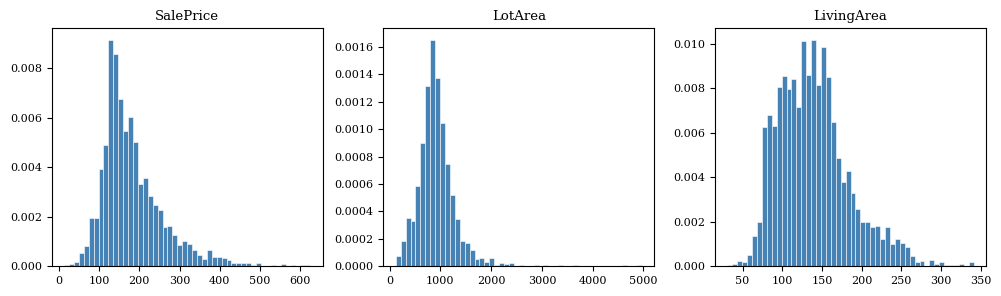

In [7]:
# Create histogram of variables in levels
columns = ['SalePrice', 'LotArea', 'LivingArea']
axes = df[columns].hist(
    bins=50,
    layout=(1, 3),
    figsize=(10, 3),
    density=True,
    sharex=False,
    grid=False,
    color='steelblue',
    edgecolor='white',
    lw=0.4,
)
axes[0, 0].figure.tight_layout()

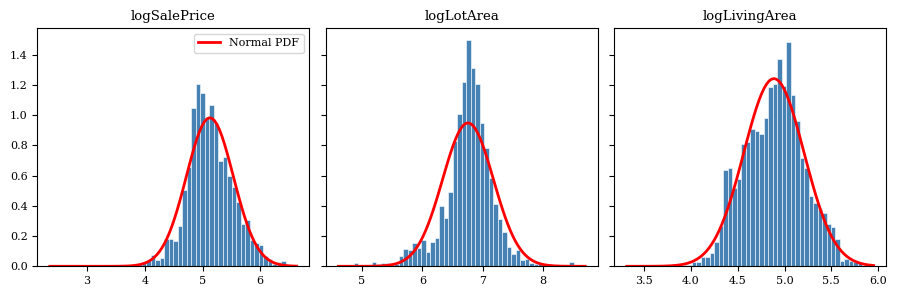

In [8]:
from scipy.stats import norm

# Create histogram of variables in logs, superimpose normal PDF
columns = ['logSalePrice', 'logLotArea', 'logLivingArea']
# Compute mean and standard deviation of logged variables
moments = df[columns].agg(['mean', 'std'])

# Create histogram of logged variables
axes = df[columns].hist(
    bins=50,
    layout=(1, 3),
    figsize=(9, 3),
    density=True,
    sharex=False,
    sharey=True,
    grid=False,
    color='steelblue',
    edgecolor='white',
    lw=0.4,
)

# Add normal PDF to each subplot
for i, ax in enumerate(axes.flatten()):
    mean, std = moments.iloc[:, i]
    xlim = ax.get_xlim()
    xvalues = np.linspace(xlim[0], xlim[1], 100)
    yvalues = norm.pdf(xvalues, mean, std)
    ax.plot(xvalues, yvalues, color='red', lw=2, label='Normal PDF')
    if i == 0:
        ax.legend()
axes[0, 0].figure.tight_layout()

***
## Part 2 — Model features

### Model specification

You are now asked to estimate the following model of house prices
as a function of house characteristics:
$$
\begin{aligned}
\log(SalePrice_i) 
    &= \alpha + f\Bigl(\log(LivingArea_i), ~
        \log(LotArea_i), OverallQuality_i,~ \\
    & \qquad \qquad \qquad  
    Bathrooms_i,~ Bedrooms_i\Bigr) \\
    &+ \gamma_0 YearBuilt_i + 
    \gamma_1 CentralAir_i + 
    \gamma_3 IsSingleFamily_i + 
    \epsilon_i
\end{aligned}
$$
where $i$ indexes observations and $\epsilon$ is an additive error term.
The function $f(\bullet)$ is a *polynomial of degree 3* in its
arguments, i.e., it includes all terms and interactions of the given variables
where the exponents sum to 3 or less:
$$
\begin{aligned}
f(\log(LivingArea_i), \log(LotArea_i), \dots)
    &= \beta_0 \log(LivingArea_i) 
    + \beta_1 \log(LivingArea_i)^2 \\
    &+ \beta_2 \log(LivingArea_i)^3 
    + \beta_3 \log(LotArea_i) \\
    &+ \beta_4 \log(LotArea_i)^2
    + \beta_5 \log(LotArea_i)^3 \\
    &+ \beta_6 \log(LivingArea_i)\log(LotArea_i) \\
    &+ \beta_7 \log(LivingArea_i)^2 \log(LotArea_i) \\
    &+ \beta_8 \log(LivingArea_i) \log(LotArea_i)^2 \\
    &+ \cdots 
\end{aligned}
$$

### Creating model features and outcomes


1.  Complete the template code below to create a feature matrix `X` which contains all polynomial interactions as well as the remaining non-interacted variables.

    *Hints:* 

    - Use the 
    [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
    transformation to create the polynomial terms and interactions from the columns
        `logLivingArea`, `logLotArea`, `OverallQuality`, `Bathrooms` and  `Bedrooms`.
    - Make sure that the generated polynomial does *not* contain a 
    constant ("bias"). You should include the intercept when estimating a model instead.
    - You can use [`np.hstack()`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) to concatenate two matrices (the polynomials and the remaining covariates) along the column dimension.
    - The complete feature matrix `X` should contain a total of 58 columns (55 polynomial interactions and 3 non-polynomial features).

2.  Split the data into a training and a test subset such that the training
sample contains 70% of observations.

    *Hint:* 

    - Use the function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the sample.
        Pass the argument `random_state=1234` to get reproducible results.
    - Make sure to define the training and test samples only *once* so that they are identical for all estimators used below. 

In [9]:
# Random state (for train/test split and cross-validation)
RANDOM_STATE = 1234      

# Name of target variable
target = 'logSalePrice'

# Features included as polynomials
features_poly = [
    'logLivingArea',
    'logLotArea',
    'OverallQuality',
    'Bathrooms',
    'Bedrooms',
]

# Other features not included in polynomials
features_other = ['YearBuilt', 'CentralAir', 'IsSingleFamily']
features = features_poly + features_other

# Keep only columns that are used to estimate model
columns = [target] + features
df = df[columns]

# Response variable
y = df[target]

# TODO: Create polynomial features

# TODO: Merge polynomial features and non-polynomial features into single matrix X

# TODO: Split data into training and test sets

### Solution

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Random state (for train/test split and cross-validation)
RANDOM_STATE = 1234

# Endogenous (target) variable
target = 'logSalePrice'

# Features included as polynomials
features_poly = [
    'logLivingArea',
    'logLotArea',
    'OverallQuality',
    'Bathrooms',
    'Bedrooms',
]

# Other features not included in polynomials
features_other = ['YearBuilt', 'CentralAir', 'IsSingleFamily']
features = features_poly + features_other

# Keep only columns that are used to estimate model
columns = [target] + features
df = df[columns]

# Response variable
y = df[target]

# Create polynomials of degree 3 or less, excluding intercept
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(df[features_poly])
print(f'Number of polynomial features: {X_poly.shape[1]}')

# Remaining features that are not use in polynomial
X_other = df[features_other]
print(f'Number of non-polynomial features: {X_other.shape[1]}')

# Create final feature matrix
X = np.hstack((X_poly, X_other))

# Print number of features and observations in final sample
print(f'Number of features: {X.shape[1]:,d}')
print(f'Number of observations: {X.shape[0]:,d}')

Number of polynomial features: 55
Number of non-polynomial features: 3
Number of features: 58
Number of observations: 2,755


The helper function 
[`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
can be used to randomly assign 70% of observations to the training sub-set.

In [11]:
from sklearn.model_selection import train_test_split

# Fraction assigned to test sub-set
test_size = 0.3

# Split feature matrix and target variable
X_train, X_test, y_train, y_test  = train_test_split(
    X, y, 
    test_size=test_size,
    random_state=RANDOM_STATE
)

print(f'Number of observation in training sample: {X_train.shape[0]:,d}')
print(f'Number of observation in test sample: {X_test.shape[0]:,d}')

Number of observation in training sample: 1,928
Number of observation in test sample: 827


***
## Part 3 — Linear regression

Perform the following tasks:

1. Estimate the above specification using the linear regression model 
    [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) on the training sub-set. 

    -   Do you need to standardize features before estimating a linear regression model? 
    -   Does the linear regression model have any hyperparameters?

2. Compute and report the root mean squared error (RMSE) and the $R^2$ on the test sample.

*Hints:*

- The root mean squared error can be computed with [`root_mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html).

- The $R^2$ can be computed with 
    [r2_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

### Solution

A plain linear regression model can be estimated using
[`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). 

- In general, no standardization is needed for linear regression models. In cases where the 
    feature matrix contains columns of vastly different magnitudes, standardization may be 
    beneficial for numerical stability.
    
- The linear regression model in general does not have any hyperparameters. We could view the polynomial degree used to create the feature matrix as a hyperparameter, but we don't tune this parameter in this exercise.

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)

LinearRegression()

To compute the RMSE on the test sample, we use the helper function
[`root_mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html).
We compute the $R^2$ using 
[`r2_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

In [13]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Predict outcome on the test sample
y_test_pred = lr.predict(X_test)

# Compute RMSE and R2 on test sample
rmse_lr = root_mean_squared_error(y_test, y_test_pred)
r2_lr = r2_score(y_test, y_test_pred)

print(f'RMSE for linear regression (test sample): {rmse_lr:,.5g}')
print(f'R2 for linear regression (test sample): {r2_lr:,.5g}')

RMSE for linear regression (test sample): 0.15046
R2 for linear regression (test sample): 0.85814


***
## Part 4 — Ridge regression

Next, you want to estimate a Ridge regression which has the regularization
strength $\alpha$ as a hyperparameter.

1. Use the template code below to run [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
    to determine the best $\alpha$ on the training sub-sample.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.

    - Does Ridge regression require feature standardization? If so, don't forget to apply it before fitting the model.
2. Use the function `plot_validation_curve()` defined below to plot the MSE (averaged over folds on the training sub-sample) against the regularization strength $\alpha$.
3. Compute and report the RMSE and the $R^2$ on the test sample.

*Hints:* 
-   Create `RidgeCV` with `store_cv_results=True` to store the MSEs on all folds. 
-   The MSEs for all folds and alphas are stored in the attribute `cv_results_` after fitting.
-   The (negative!) best MSE is stored in the attribute `best_score_` after fitting.

In [14]:
import matplotlib.pyplot as plt

def plot_validation_curve(alphas, mse_mean, title=None):
    """
    Plot validation curve for Ridge or Lasso.

    Parameters
    ----------
    alphas : array-like
        Regularization strengths.
    mse_mean : array-like
        Cross-validated MSE (averaged over folds).
    title : str, optional
        Title of the plot.
    """

    # Index of MSE-minimizing alpha
    imin = np.argmin(mse_mean)

    # Plot MSE against alphas, highlight minimum MSE
    plt.plot(alphas, mse_mean)
    plt.xlabel(r'Regularisation strength $\alpha$ (log scale)')
    plt.ylabel('Cross-validated MSE')
    plt.scatter(alphas[imin], mse_mean[imin], s=15, c='black', zorder=100)
    plt.axvline(alphas[imin], ls=':', lw=0.75, c='black')
    plt.title(title)
    plt.xscale('log')

In [15]:
# TODO: Manually transform features

# TODO: Create alpha grid uniformly spaced in logs on [1e-6, 100]
# alphas = 

# TODO: Create RidgeCV and fit model
# ridge_cv = 

# TODO: Report the best alpha and the corresponding MSE score

# TODO: Compute MSEs averaged across folds (stored in cv_results_)
# mse_mean = 

# TODO: Plot validation curve
# plot_validation_curve(alphas, mse_mean)

# TODO: compute and report RMSE and R2 on the test sample

#### Solution

The Ridge regression is sensitive to scaling so we standardize the features before fitting the model. Note that `RidgeCV` does not support pipelines, so we need to standardize the feature matrix manually before performing the cross-validation.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# Create transformation to standardize features
transform = StandardScaler()

# Standardize features in training sample
X_train_trans = transform.fit_transform(X_train)

# Grid of regularization parameters
alphas = np.logspace(np.log10(1.0e-6), np.log10(100), 1000)

# Create RidgeCV instance with candidate alphas
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)

# Fit Ridge regression, find optimal alpha
ridge_cv.fit(X_train_trans, y_train)

RidgeCV(alphas=array([1.00000000e-06, 1.01861017e-06, 1.03756668e-06, 1.05687597e-06,
       1.07654461e-06, 1.09657929e-06, 1.11698682e-06, 1.13777413e-06,
       1.15894830e-06, 1.18051653e-06, 1.20248614e-06, 1.22486461e-06,
       1.24765955e-06, 1.27087871e-06, 1.29452998e-06, 1.31862140e-06,
       1.34316117e-06, 1.36815763e-06, 1.39361927e-06, 1.41955477e-06,
       1.44597292e-06, 1.47288272e-0...
       6.54358602e+01, 6.66536327e+01, 6.78940681e+01, 6.91575883e+01,
       7.04446228e+01, 7.17556092e+01, 7.30909933e+01, 7.44512291e+01,
       7.58367791e+01, 7.72481145e+01, 7.86857151e+01, 8.01500696e+01,
       8.16416760e+01, 8.31610415e+01, 8.47086827e+01, 8.62851257e+01,
       8.78909065e+01, 8.95265713e+01, 9.11926760e+01, 9.28897872e+01,
       9.46184819e+01, 9.63793480e+01, 9.81729841e+01, 1.00000000e+02]),
        store_cv_results=True)

Once we have completed cross-validation, we can recover the optimal $\alpha$ from the `alpha_` attribute. The best MSE is stored in the attribute `best_score_`.

In [17]:
# Recover best alpha that minimizes MSE
alpha_best = ridge_cv.alpha_

# Best MSE is stored as negative score!
MSE_best = - ridge_cv.best_score_

print(f'Best alpha: {alpha_best:.3g} (MSE: {MSE_best:,.5g})')

Best alpha: 0.476 (MSE: 0.023884)


The MSEs for each validation set and each candidate $\alpha$ are stored in the attribute `cv_results_` which has shape `(N_OBS, N_ALPHAS)`. This is because by default `RidgeCV` performs leave-one-out cross-validation (which is more efficient), so the number of folds equals the number of observations. To get the MSE across folds, we need to average out the first dimension of this array.

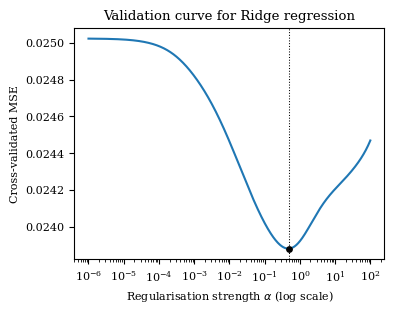

In [18]:
# Compute average MSE for each alpha value across all folds
mse_mean = np.mean(ridge_cv.cv_results_, axis=0)

# Plot validation curve
plot_validation_curve(
    alphas,
    mse_mean,
    title='Validation curve for Ridge regression',
)

Lastly, we compute the RMSE and the $R^2$ and store them for later.

In [19]:
from sklearn.linear_model import Ridge

# Transform test features
X_test_trans = transform.transform(X_test)

y_test_pred = ridge_cv.predict(X_test_trans)
rmse_ridge = root_mean_squared_error(y_test, y_test_pred)
r2_ridge = r2_score(y_test, y_test_pred)

print(f'RMSE for Ridge regression (test sample): {rmse_ridge:,.5g}')
print(f'R2 for Ridge regression (test sample): {r2_ridge:,.5g}')

RMSE for Ridge regression (test sample): 0.1493
R2 for Ridge regression (test sample): 0.86033


***
## Part 5 — Lasso

Next, you want to estimate a Lasso model which also has a regularization strength hyperparameter
$\alpha$:

1. Use the template below to run [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
    to determine the best $\alpha$ on the training sub-sample
    using cross-validation with 5 folds.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.

    - Does Lasso require feature standardization? If so, don't forget to apply it before fitting the model.

2. Use the function `plot_validation_curve()` to plot the MSE (averaged over folds on the training sub-sample) against the regularization strength $\alpha$.
3. Compute and report the RMSE and the $R^2$ on the test sample for the model using the optimal $\alpha$.
4. Report the number of non-zero coefficients for the model using the optimal $\alpha$.

*Hints:* 

- Getting Lasso to converge may require some experimentation. The following settings should help: 

    1.  Increase the max. number of iterations to `max_iter=100_000`.
    2.  Use `selection='random'` and set `random_state=1234` to get reproducible results.

- Use `eps=1.0e-4` as an argument to `LassoCV` to specify the ratio of the smallest to the largest $\alpha$.
- After cross-validation is complete, the MSE for each value of $\alpha$ and each fold are stored in the attribute `mse_path_` which is an array with shape `(N_ALPHA, N_FOLDS)`.

In [20]:
# TODO: Run cross-validation using LassoCV. Use the transformed features from earlier.
# lasso_cv =

# TODO: Report the best alpha (stored in alpha_) 

# TODO: Compute MSEs averaged across folds (stored in mse_path_)
# mse_mean =

# TODO: Plot validation curve
# plot_validation_curve(lasso_cv.alphas_, mse_mean)

# TODO: compute and report RMSE and R2 on the test sample

# TODO: Report number of non-zero coefficients (stored in coef_)

### Solution

Just like Ridge regression, Lasso can be sensitive to scaling and we thus need to standardize the features before fitting the model.

Other than that, `LassoCV` does all the work for us, so we only need to specify the grid of candidate $\alpha$ values. Using `eps=1.0e-4` instead of the default value increases the range of candidate $\alpha$.

In [21]:
from sklearn.linear_model import LassoCV

# Define and fit Lasso CV
lasso_cv = LassoCV(eps=1.0e-4, 
    n_alphas=200,
    max_iter=100_000, 
    cv=5, 
    random_state=RANDOM_STATE, 
    selection='random',
).fit(X_train_trans, y_train)


We can recover the optional $\alpha$ and the mean MSE from the fitted object as follows:

In [22]:
# Recover best alpha that minimizes MSE
alpha_best = lasso_cv.alpha_

# MSE for each alpha, averaged over folds
mse_mean = np.mean(lasso_cv.mse_path_, axis=1)

# Index of min. MSE
imin = np.argmin(mse_mean)

mse_best = mse_mean[imin]

print(f'Best alpha: {alpha_best:.4g} (MSE: {mse_best:.5g})')

Best alpha: 5.505e-05 (MSE: 0.024201)


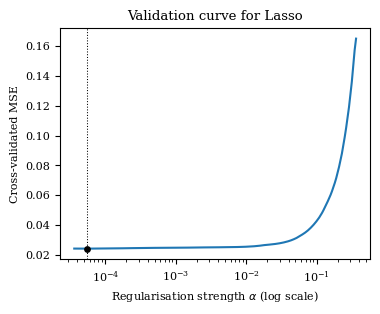

In [23]:
# Plot validation curve
plot_validation_curve(
    lasso_cv.alphas_,
    mse_mean,
    title='Validation curve for Lasso',
)

We use the fitted model to compute the RMSE and the $R^2$:

In [24]:
from sklearn.linear_model import Lasso

y_test_pred = lasso_cv.predict(X_test_trans)
rmse_lasso = root_mean_squared_error(y_test, y_test_pred)
r2_lasso = r2_score(y_test, y_test_pred)

print(f'MSE for Lasso regression (test sample): {rmse_lasso:,.5g}')
print(f'R2 for Lasso regression (test sample): {r2_lasso:,.5g}')

MSE for Lasso regression (test sample): 0.14819
R2 for Lasso regression (test sample): 0.8624


The number of non-zero coefficients can be recovered as follows:

In [25]:
Ncoefs = len(lasso_cv.coef_)
Ncoefs_nonz = np.sum(np.abs(lasso_cv.coef_) > 1.0e-8)
print(f'Number of non-zero coefficients: {Ncoefs_nonz} (out of {Ncoefs})')

Number of non-zero coefficients: 29 (out of 58)


***
## Part 6 — Compare estimation results

Create a table which contains the MSE and $R^2$ computed on the test sample for all three models (using their optimal hyperparameters). Which model performs best?

#### Solution

The following code combines the MSEs and $R^2$ computed in the previous sections and tabulates them by estimator. As can be seen, the Lasso performs best among the three estimators, yielding the smallest MSE and the highest $R^2$ on the test sub-sample.

In [26]:
# Create Table with results

# Model labels
labels = ['Linear Reg', 'Ridge', 'Lasso']

# Compute all previously estimated MSE
metrics = pd.DataFrame({'RMSE': [rmse_lr, rmse_ridge, rmse_lasso], 'R2': [r2_lr, r2_ridge, r2_lasso]}, index=pd.Index(labels, name='Model'))

# Print result table
print(metrics.to_string(float_format='{:8.4f}'.format))

               RMSE       R2
Model                       
Linear Reg   0.1505   0.8581
Ridge        0.1493   0.8603
Lasso        0.1482   0.8624


***
# Exercise 2: Classification of above-average houses

We continue with the setup from the previous exercise, but now use classification to predict whether a house was sold for more than the average price in its neighborhood.

Use the same initial data processing steps as before, which are repeated here for convenience:

In [27]:
import pandas as pd
import numpy as np

# Use this path to use the CSV file from the data/ directory
file = '../../data/ames_houses.csv'

df = pd.read_csv(file, sep=',')

# Drop rows with any missing observation
df = df.dropna()

# Drop observations with large living or lot area
df = df.query('LivingArea <= 350 & LotArea <= 5000')

# Create log-transformed variables
df['logLivingArea'] = np.log(df['LivingArea'])
df['logLotArea'] = np.log(df['LotArea'])

# Create indicator variable for single family homes
df['IsSingleFamily'] = (df['BuildingType'] == 'Single-family').astype(int)

# Create indicator variable for central air
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})

print(f'Number of observations: {df.shape[0]:,d}')

Number of observations: 2,755


***
## Part 1 — Data preprocessing

Perform the following additional data processing steps:

1.  Drop all neighborhoods with less than 40 observations.
2.  Create a new variable `MoreExpensive` which is 1 whenever the sale price is above 
    the average sale price in the neighborhood.
3.  Split the data set into two data frames, `df_train` and `df_test`, where
    the test sample should contain 20% of the observations.
    Stratify the train-test split using the indicator `MoreExpensive`.

### Solution

The easiest way to get the number of observations in each neighborhood
and assign them to each row is by using 
[`groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)
combined with a 
[`transform()`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.transform.html):

In [28]:
# Drop observations with neighborhoods with few observations
MIN_OBS = 40
nobs = df.groupby('Neighborhood').transform('size')
df = df.loc[nobs >= MIN_OBS].copy()

print(f'Number of observations: {df.shape[0]:,d}')

Number of observations: 2,656


We then use the same approach to get the average sale price for each neighborhood for each observation:

In [29]:
# Average sale price in each neighborhood
avg_price = df.groupby('Neighborhood')['SalePrice'].transform('mean')

# Create indicator whether house is more expensive than average in neighborhood.
# Indicator should be stored as an integer (0/1)
df['MoreExpensive'] = ( df['SalePrice'] > avg_price).astype(int)

# Tabulate class labels
df['MoreExpensive'].value_counts()

MoreExpensive
0    1503
1    1153
Name: count, dtype: int64

Once the data is processed, we split it into two data frames, one for the training and one for the test sample.

In [30]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 1234

# Fraction assigned to test sub-set
test_size = 0.2

# Split data set
df_train, df_test  = train_test_split(
    df, 
    test_size=test_size,
    stratify=df['MoreExpensive'],
    random_state=RANDOM_STATE
)

print(f'Number of observation in training sample: {df_train.shape[0]:,d}')
print(f'Number of observation in test sample: {df_test.shape[0]:,d}')

Number of observation in training sample: 2,124
Number of observation in test sample: 532


***
## Part 2 — Logistic regression

Using the template code below, create the feature matrix for the logistic regression as follows:

1.  Create polynomials of degree 3 using the variables `LivingArea`, `LotArea`,
    `OverallQuality`, `OverallCondition`, `Bathrooms`, `Bedrooms`, `Fireplaces`, and
    `YearRemodeled`

2.  Add the non-interacted features 
    `CentralAir`, and `IsSingleFamily` to the feature matrix.

Then perform the following steps to fit and evaluate the model:

1.  Fit the logistic regression with 
[`LogisticRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
using the indicator `MoreExpensive` as the target variable.

    -   Does the logistic regression require feature standardization? If so,
    you need to transform the features using
    [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

    -   You can use the default parameters for `LogisticRegression`, but you might need to increase
    the maximum number of iterations (e.g., `max_iter=10_000`).

2.  After you have fitted the model, use the function
    `tabulate_classifier_metrics()` defined below to tabulate the accuracy,
    precision, recall, and the F1 store on the test sample.

3.  After you have fitted the model, use the function
    `plot_confusion_matrix()` defined below to plot the confusion matrix
    on the test sample.

    This function calls
    [ConfusionMatrixDisplay.from_estimator()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_estimator)
    to create a confusion matrix graph.


In [31]:
from sklearn.preprocessing import PolynomialFeatures

# Target variable name
target = 'MoreExpensive'

# Features included as polynomials (in logistic regression)
features_poly = [
    'LivingArea',
    'LotArea',
    'OverallQuality',
    'OverallCondition',
    'Bathrooms',
    'Bedrooms',
    'Fireplaces',
    'YearRemodeled'
]

# Other features not included in polynomials
features_other = ['CentralAir', 'IsSingleFamily']
features = features_poly + features_other

# Response variable
y_train = df_train[target]
y_test = df_test[target]

# TODO: Create polynomial features for training sample

# TODO: Create polynomial features for test sample

# TODO: Merge polynomial features and non-polynomial features into X_train

# TODO: Merge polynomial features and non-polynomial features into X_test

# TODO: Standardize features

# TODO: Fit logistic regression model

# TODO: Tabulate metrics on test sample using tabulate_classification_metrics()

# TODO: Plot confusion matrix using plot_confusion_matrix()

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def tabulate_classifier_metrics(estimator, X, y):
    """
    Tabulate classification metrics (accuracy, precision, recall, F1).

    Parameters
    ----------
    estimator : object
        Fitted classifier.
    X : array-like
        Feature matrix.
    y : array-like
        Target variable.
    """

    # Predict outcome
    y_pred = estimator.predict(X)

    # Compute scores
    acc = accuracy_score(y, y_pred)
    pre = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Combine scores into a single Series
    index = pd.Index(
        ['Accuracy', 'Precision [TP/(TP+FP)]', 'Recall [TP/P]', 'F1'], name='Metric'
    )
    stats = pd.Series([acc, pre, rec, f1], index=index)

    stats = stats.round(3)

    return stats

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(estimator, X, y, title='Confusion matrix'):
    """
    Plot confusion matrix for classification model.

    Parameters
    ----------
    estimator : estimator
        Fitted classification model.
    X : array-like
        Feature matrix.
    y : array-like
        Target variable.
    title : str
        Title of the plot.
    """

    cm = ConfusionMatrixDisplay.from_estimator(
        estimator=estimator,
        X=X,
        y=y,
        values_format=',d',
        cmap='Blues',
        colorbar=False,
        text_kw={'fontsize': 10, 'fontweight': 'bold'},
    )
    cm.ax_.set_title(title)

### Solution

The code to create the polynomial features follows the same logic as in Exercise 1. We defer the feature standardization to later since we need to also standardize the non-polynomial features when fitting a model with regularization.

In [34]:
# Create polynomials of degree 3 or less, excluding intercept
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(df_train[features_poly])
X_test_poly = poly.transform(df_test[features_poly])
print(f'Number of polynomial features: {X_train_poly.shape[1]}')

# Remaining features that are not use in polynomial
X_train_other = df_train[features_other]
X_test_other = df_test[features_other]

print(f'Number of non-polynomial features: {X_train_other.shape[1]}')

# Create final feature matrix
X_train = np.hstack((X_train_poly, X_train_other))
X_test = np.hstack((X_test_poly, X_test_other))

Number of polynomial features: 164
Number of non-polynomial features: 2


With the feature matrix in hand, we standardize the features and fit the logistic regression:

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Create transformer for standardization
transform = StandardScaler()

# Fit and transform training features
X_train_trans = transform.fit_transform(X_train)
# Transform test features
X_test_trans = transform.transform(X_test)

# Define and fit logistic regression with cross-validation
logit = LogisticRegression(max_iter=10_000).fit(X_train_trans, y_train)


Once the model is fitted, we call the function define above to obtain a list of accuracy metrics for the test sample.

In [36]:
# Compute accuracy, precision, recall, and F1 score
tbl_logit = tabulate_classifier_metrics(logit, X_test_trans, y_test)
# Convert to DataFrame
tbl_logit = tbl_logit.to_frame('Logistic')
tbl_logit

,Logistic
Metric,
Accuracy,0.703
Precision [TP/(TP+FP)],0.665
Recall [TP/P],0.636
F1,0.650


Finally, we call `plot_confusion_matrix()` to plot the confusion matrix on the test sample.

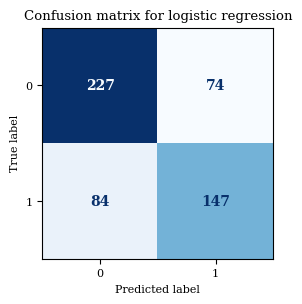

In [37]:
# Plot confusion matrix
plot_confusion_matrix(
    logit, X_test_trans, y_test, title='Confusion matrix for logistic regression'
)

As you can see from the above metrics, the model is doing worst when it comes to recall, i.e., correctly classifying true labels.

***
## Part 3 — Logistic regression CV

Instead of using the default regularization strength `C=1`, perform cross-validation 
to find the optimal value of $C$:

1. Run the cross-validation with
[LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html).

    Create a log-spaced grid of candidate values as follows:

    ```python
    C_grid = np.logspace(-2, 2, 500)
    ```
2.  Report the optimal value of $C$.
3.  After you have fitted the model, use the function
    `tabulate_classifier_metrics()` to tabulate the accuracy,
    precision, recall, and the F1 store on the test sample.

3.  After you have fitted the model, use the function
    `plot_confusion_matrix()` defined below to plot the confusion matrix
    on the test sample.

### Solution

When running cross-validation, we can choose a scoring metric which is used to evaluate the predictive performance on the validation sample. By default, this metric is the accuracy score, but we can 
choose other metrics defined in the 
[`sklearn.metrics`](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics)
module. For example, we choose F1 below:

In [38]:
from sklearn.linear_model import LogisticRegressionCV

C_grid = np.logspace(-2, 2, 500)

# Define and fit logistic regression with cross-validation
logit_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=5,
    penalty='l2',
    max_iter=100_000,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit=True
).fit(X_train_trans, y_train)

Once the fitting is complete, the optimal regularization strength is stored in the `C_` attribute. Note that this attribute is an array.

In [39]:
C_best = logit_cv.C_[0]
print(f'Best cross-validated C: {C_best:.3f}')

Best cross-validated C: 8.588


We can directly use the cross-validated model to make predictions and compute the metrics of interest:

In [40]:
# Compute accuracy, precision, recall, and F1 score
tbl_logit_cv = tabulate_classifier_metrics(logit_cv, X_test_trans, y_test)
# Convert to DataFrame
tbl_logit_cv = tbl_logit_cv.to_frame('Logistic (CV)')
tbl_logit_cv


,Logistic (CV)
Metric,
Accuracy,0.705
Precision [TP/(TP+FP)],0.668
Recall [TP/P],0.636
F1,0.652


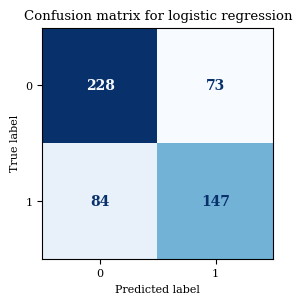

In [41]:
# Plot confusion matrix
plot_confusion_matrix(
    logit_cv, X_test_trans, y_test, title='Confusion matrix for logistic regression'
)

The results show that the cross-validated model is doing only marginally better than using the default value of $C$.

***
## Part 4 — Random forest

You now want to investigate how other classifiers perform on this task compared
to logistic regression.

1.  Fit the Random forest classifier implemented in 
    [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to the data. Use the default parameters for now.

    -   Do you need to include polynomial interactions with Random forest?
    -   Do you need to standardize the features with Random forest?

2.  After you have fitted the model, use the function
    `tabulate_classifier_metrics()` to tabulate the accuracy,
    precision, recall, and the F1 store on the test sample.

3.  After you have fitted the model, use the function
    `plot_confusion_matrix()` defined below to plot the confusion matrix
    on the test sample.

### Solution

In principle, including all the polynomial interactions into the Random forest classifier should not be needed as the Random forest does not impose any functional form on how the features enter the classification
in the first place (unlike logistic regression).
However, fitting the model with and without polynomial features will result in different predictions, and it's not clear ex ante which one is better.
In any case, including polynomial features increases the computational burden, in particular with
cross-validation, so the default should be to not include them.

There is no need to standardize features for the Random forest.

Note that the Random forest grows decision trees on bootstrapped subsamples of the training data by default. These bootstrapped samples are created using RNG, so you need to specify a seed using `random_state` for reproducibility.


In [42]:
from sklearn.ensemble import RandomForestClassifier

X_train = df_train[features]
X_test = df_test[features]

# Define and fit random forest classifier. Use seed for reproducibility.
forest = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)

In [43]:
# Compute accuracy, precision, recall, and F1 score
tbl_forest = tabulate_classifier_metrics(forest, X_test, y_test)
# Convert to DataFrame
tbl_forest = tbl_forest.to_frame('Random Forest')
tbl_forest

,Random Forest
Metric,
Accuracy,0.697
Precision [TP/(TP+FP)],0.659
Recall [TP/P],0.628
F1,0.643


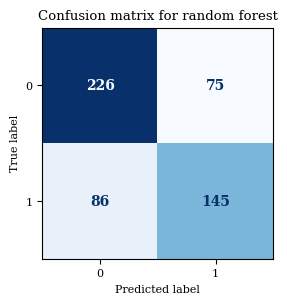

In [44]:
plot_confusion_matrix(
    forest, X_test, y_test, title='Confusion matrix for random forest'
)

***
## Part 5 — Random forest CV

In the previous part, you used the default hyperparameters for the Random
forest (e.g., the number of trees to grow and the maximum depth).

1.  Perform cross-validation of these parameters with
    [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), using the parameter grids defined in the template below.

2.  After you have fitted the model, use the function
    `tabulate_classifier_metrics()` to tabulate the accuracy,
    precision, recall, and the F1 store on the test sample.

3.  After you have fitted the model, use the function
    `plot_confusion_matrix()` defined below to plot the confusion matrix
    on the test sample.

In [45]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': np.arange(100, 201, 10),
    'max_depth': np.arange(3, 20),
}

# TODO: Call GridSearchCV to find optimal hyperparameters

# TODO: Report optimal number of estimators stored in best_params_

# TODO: Report optimal max depth stored in best_params_

### Solution

As with other cross-validators for classification, we can specify a scoring metric other than the default accuracy store. We opt to use the F1 score in this exercise.

In [46]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': np.arange(100, 201, 10),
    'max_depth': np.arange(3, 20),
}

# Create and run cross-validation via grid search
forest_cv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=False
).fit(X_train, y_train)

The cross-validated optimal hyperparameters are reported below:

In [47]:
best_max_depth = forest_cv.best_params_['max_depth']
best_n_estimators = forest_cv.best_params_['n_estimators']
print(f'Best max_depth: {best_max_depth}')
print(f'Best n_estimators: {best_n_estimators}')

Best max_depth: 9
Best n_estimators: 130


In [48]:
# Compute accuracy, precision, recall, and F1 score
tbl_forest_cv = tabulate_classifier_metrics(forest_cv, X_test, y_test)
# Convert to DataFrame
tbl_forest_cv = tbl_forest_cv.to_frame('Random Forest (CV)')
tbl_forest_cv

,Random Forest (CV)
Metric,
Accuracy,0.724
Precision [TP/(TP+FP)],0.689
Recall [TP/P],0.662
F1,0.675


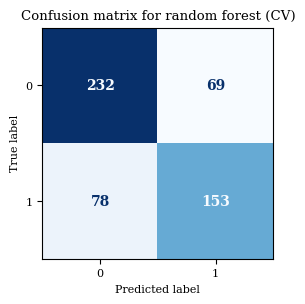

In [49]:
plot_confusion_matrix(
    forest_cv, X_test, y_test, title='Confusion matrix for random forest (CV)'
)

***
## Part 6 — Compare estimation results

Combine the accuracy, presion, recall, and F1 metrics for all the models you estimated and report them in a single table. Which estimator does best on the classification task?

### Solution

We use `pd.concat()` to concatenate all models along the column axis:

In [50]:
results = pd.concat([tbl_logit, tbl_logit_cv, tbl_forest, tbl_forest_cv], axis=1)
results.columns.name = 'Model'
results


Model,Logistic,Logistic (CV),Random Forest,Random Forest (CV)
Metric,,,,
Accuracy,0.703,0.705,0.697,0.724
Precision [TP/(TP+FP)],0.665,0.668,0.659,0.689
Recall [TP/P],0.636,0.636,0.628,0.662
F1,0.650,0.652,0.643,0.675


As you can see, the Random forest with cross-validated hyperparameters performs best.